In [5]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
from datetime import date, datetime, timedelta
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import altair as alt
# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [188]:
df = pd.read_csv('./data/VietnamConflict.csv')

In [189]:
# NOTE: ALTAIR ONLY WORKS IF COLUMN CONVERTED TO DATETIME WITH PD.TO_DATETIME,
df.FATALITY_DATE = pd.to_datetime(df.FATALITY_DATE, format='%Y%m%d', errors='ignore')

df['FATALITY_MONTH'] = df['FATALITY_DATE'].dt.strftime('%b')

misaligned_dates = df[(df['FATALITY_YEAR'] - df['FATALITY_DATE'].dt.strftime("%Y").astype(int)) != 0]
df = df[~df.index.isin(misaligned_dates.index)]

df['DEPLOYMENT_PROVINCE'].fillna('UNKNOWN', inplace=True)

df['DEPLOYMENT_PROVINCE'] = df['DEPLOYMENT_PROVINCE'].str.title()

# Rename the provinces 
recategorize = {'Thua Thien': 'Thua Thien - Hue',\
                'Kontum': 'Kon Tum',\
                'Darlac': 'Dak Lak|Dac Lac',\
                'Gia Dinh': 'Ho Chi Minh City|Ho Chi Minh',\
                'Phuoc Tuy': 'Ba Ria - VTau|Ba Ria-Vung Tau',\
                'Pleiku': 'Gia Lai',\
                'Bien Hoa': 'Dong Nai'}

df.replace({"DEPLOYMENT_PROVINCE": recategorize}, inplace=True)

In [190]:
df1 = df[['FATALITY_MONTH', 'FATALITY_YEAR', 'DEPLOYMENT_PROVINCE','HOSTILITY_CONDITIONS']]

In [193]:
df2 = df1.groupby(['FATALITY_YEAR', 'FATALITY_MONTH', 'DEPLOYMENT_PROVINCE'])['HOSTILITY_CONDITIONS'].count()\
        .reset_index().rename(columns={'HOSTILITY_CONDITIONS': 'count'})
df2.to_csv("./data/VietnamConflict2.csv", index=False)

In [180]:
#df1 = pd.pivot_table(df1, index='FATALITY_MONTH', columns='FATALITY_YEAR', aggfunc=len, fill_value=0).reset_index()
df1 = df1.groupby(['FATALITY_YEAR', 'FATALITY_MONTH'])['HOSTILITY_CONDITIONS'].count()\
        .reset_index().rename(columns={'HOSTILITY_CONDITIONS': 'count'})
df1.to_csv("./data/VietnamConflict1.csv", index=False)

In [192]:
df2

,FATALITY_YEAR,FATALITY_MONTH,DEPLOYMENT_PROVINCE,count
0,1961,Apr,Ho Chi Minh City|Ho Chi Minh,1
1,1961,Apr,Unknown,2
2,1961,Dec,Unknown,1
3,1961,Jun,Ho Chi Minh City|Ho Chi Minh,1
4,1961,Mar,Unknown,7
5,1962,Apr,Ho Chi Minh City|Ho Chi Minh,1
6,1962,Apr,Unknown,4
7,1962,Dec,Unknown,2
8,1962,Feb,Dong Nai,3
9,1962,Feb,Lam Dong,1


In [6]:
with open("./data/vietnam1.json", "r") as f:
    json_obj = json.loads(f.read())
    vietnam = pd.DataFrame(json_obj['features'])
    
all_provinces = [i['VARNAME_1'] for i in vietnam.properties]

In [7]:
print('The number of provinces listed in the shapefile is', len(all_provinces))

The number of provinces listed in the shapefile is 63


In [8]:
print('The number of provinces with US troop deaths are', len(df.DEPLOYMENT_PROVINCE.unique()))

The number of provinces with US troop deaths are 49


In [9]:
def group_deaths_perc(df, all_provinces):
    
    g = (df.groupby('DEPLOYMENT_PROVINCE')['FATALITY_DATE'].count().sort_values(ascending=False) / len(df))*100
    death_perc = pd.DataFrame(g).reset_index().rename(columns={'FATALITY_DATE': 'percentage'})
    death_perc = pd.merge(pd.DataFrame(all_provinces).rename(columns={0:'DEPLOYMENT_PROVINCE'}), \
                          death_perc, on='DEPLOYMENT_PROVINCE', how='left')
    death_perc['percentage'].fillna(0, inplace=True)
    
    death_perc.to_csv("./data/deathPercentages_byProvince.csv", index=False)
    
    return death_perc

In [10]:
death_perc = group_deaths_perc(df, all_provinces)

In [226]:
def group_deaths_count(df, all_provinces):
    
    g = df.groupby('DEPLOYMENT_PROVINCE')['FATALITY_DATE'].count().sort_values(ascending=False)
    death_perc = pd.DataFrame(g).reset_index().rename(columns={'FATALITY_DATE': 'count'})
    death_perc = pd.merge(pd.DataFrame(all_provinces).rename(columns={0:'DEPLOYMENT_PROVINCE'}), \
                          death_perc, on='DEPLOYMENT_PROVINCE', how='left')
    death_perc['count'].fillna(0, inplace=True)
    
    death_perc = death_perc.sort_values('count', ascending=False)
    death_perc.to_csv("./data/deathPercentages_byProvince.csv", index=False)
    
    return death_perc

In [227]:
death_count = group_deaths_count(df, all_provinces)

In [228]:
death_count

,DEPLOYMENT_PROVINCE,count
46,Quang Nam,7813.0
49,Quang Tri,7246.0
47,Quang Ngai,2882.0
8,Binh Duong,2680.0
52,Tay Ninh,2575.0
7,Binh Dinh,2321.0
33,Kon Tum,1591.0
16,Dong Nai,1267.0
20,Gia Lai,1044.0
38,Long An,986.0


In [216]:
def drawstates(df, shapefile='gadm36_VNM_1'):
    
        # Draw Map
        fig, ax = plt.subplots(figsize=(8,10))
        m = Basemap(llcrnrlon=100.8,llcrnrlat=7.9,urcrnrlon=110.6,urcrnrlat=24,
                    resolution='i',projection='merc')
        m.ax = ax
        m.fillcontinents(color='#ffffff')

        # Use shapefile to draw areas and regions
        shp = m.readshapefile(shapefile, 'states', drawbounds=True)
        for nshape, seg in enumerate(m.states):
            poly = Polygon(seg, facecolor='0.75', edgecolor='k')
            m.ax.add_patch(poly)
         
        # Create a dataframe of area shape and its corresponding number
        df_poly = pd.DataFrame({
                'shapes': [Polygon(np.array(shape), True) for shape in m.states],
                'SHAPENUM': [state['SHAPENUM'] for state in m.states_info]
            })
        # Match area names given in input dataframe with that listed in shapefile
        matched_areas = pd.merge(df, pd.DataFrame(m.states_info).rename(columns={'VARNAME_1': 'DEPLOYMENT_PROVINCE'}), \
                 on='DEPLOYMENT_PROVINCE', how='left')
        matched_areas = matched_areas[matched_areas['DEPLOYMENT_PROVINCE'] != 'Unknown']

        df_poly = pd.merge(matched_areas, df_poly, on='SHAPENUM', how='left')
        df_poly = df_poly[~df_poly['shapes'].isnull()]

        # Use data to colour in areas
        cmap = plt.get_cmap('Greys')   
        pc = PatchCollection(df_poly.shapes, zorder=2)
        norm = Normalize()

        pc.set_facecolor(cmap(norm(df_poly['percentage'].fillna(0).values)))
        m.ax.add_collection(pc)

        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        mapper.set_array(df_poly['percentage'])
        plt.colorbar(mapper, shrink=0.4)
        
        #for i,row in df_poly.iterrows():
            #xx = df_poly.loc[i, 'shapes'].get_xy()[0][0]
            #yy = df_poly.loc[i, 'shapes'].get_xy()[0][1]
            #x, y = m(xx, yy)
            #plt.text(x, y, df_poly.loc[i, 'DEPLOYMENT_PROVINCE'], fontsize=10)

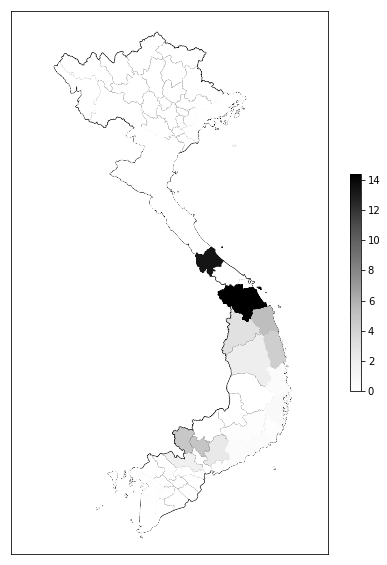

In [12]:
drawstates(death_perc)

Hua Nghia was dissolved in February 1976 and land was split amongst three neighboring provinces. Trảng Bàng district was merged to Tây Ninh Province, Củ Chi district was merged to Gia Định Province, and Đức Huệ and Đức Huệ districts were merged to Long An Province.

In [230]:
def group_deaths_time(df, all_provinces):
    
    year_months = pd.DataFrame(pd.date_range(start='1965 March', end='1973 March', freq='MS').strftime("%Y %b").tolist())\
                .rename(columns={0: 'FATALITY_DATE'})

    g = df.groupby([df['FATALITY_DATE'].dt.strftime("%Y %b"), "DEPLOYMENT_PROVINCE"])['FATALITY_YEAR'].count()
    df = pd.DataFrame(g).reset_index().rename(columns={'FATALITY_YEAR': 'count'})

    df = pd.merge(year_months, df, on='FATALITY_DATE', how='left')
    df.FATALITY_DATE = pd.to_datetime(df.FATALITY_DATE, format='%Y %b')

    df['count'] = df['count'].fillna(0)
    
    df = pd.pivot_table(df, values='count', index='DEPLOYMENT_PROVINCE', columns='FATALITY_DATE', fill_value=0).reset_index()
    
    df = pd.merge(pd.DataFrame(all_provinces).rename(columns={0:'DEPLOYMENT_PROVINCE'}), df, on='DEPLOYMENT_PROVINCE', how='left')
    df = df.fillna(0)
    mapper = lambda x: x.strftime("%Y %b") if isinstance(x, datetime) else x
    df.columns = df.columns.map(mapper)

    df.to_csv("./data/deathPercentages_byProvince_byTime_PT.csv", index=False)

    return df

In [231]:
df_grouped = group_deaths_time(df, all_provinces)

In [229]:
df_grouped

,DEPLOYMENT_PROVINCE,1965 Mar,1965 Apr,1965 May,1965 Jun,1965 Jul,1965 Aug,1965 Sep,1965 Oct,1965 Nov,...,1972 Jun,1972 Jul,1972 Aug,1972 Sep,1972 Oct,1972 Nov,1972 Dec,1973 Jan,1973 Feb,1973 Mar
0,An Giang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bac Lieu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bac Giang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bac Kan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bac Ninh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Ben Tre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Ba Ria - Vung Tau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Binh Dinh,0.0,1.0,0.0,0.0,2.0,5.0,4.0,7.0,1.0,...,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Binh Duong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Binh Phuoc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
